# Analysis of results

## Data visualization

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ranksums

In [8]:
process_set_up = {
    "difficult_sequential": "D-SEQ",
    "difficult_parallel": "D-PAR",
    "curriculum_sequential": "C-SEQ",
    "curriculum_parallel": "C-PAR",
    "curriculum_parallel_gradual": "C-GRAD"
}
pop_size = 100

In [9]:
results_dfs = []
validation_dfs = []
progressions_dfs = []
for seed in range(10):
    for set_up in process_set_up.keys():
        try:
            if set_up == "curriculum_parallel_gradual":
                curr_df = pd.read_csv(f"{set_up}_seed_{seed}_{seed}/metrics.csv")
                val_df = pd.read_csv(f"{set_up}_seed_{seed}_{seed}/validation.csv")
            else:
                curr_df = pd.read_csv(f"{set_up}_long_seed_{seed}_{seed}/metrics.csv")
                val_df = pd.read_csv(f"{set_up}_long_seed_{seed}_{seed}/validation.csv")
            curr_df["seed"] = f"s_{seed}"
            curr_df["fitness_evaluation"] = curr_df["generation"] * pop_size * (3 if "parallel" in set_up else 1)
            curr_df["set_up"] = set_up
            curr_df["short_set_up"] = process_set_up[set_up]
            results_dfs.append(curr_df)
            val_df["seed"] = f"s_{seed}"
            val_df["set_up"] = set_up
            val_df["short_set_up"] = process_set_up[set_up]
            validation_dfs.append(val_df)
            # this will only work for sequential ones
            if "sequential" in set_up:
                progr_df = pd.read_csv(f"{set_up}_long_seed_{seed}_{seed}/progression.csv")
                progr_df["seed"] = f"s_{seed}"
                progr_df["fitness_evaluation"] = progr_df["generation"] * pop_size * (3 if "parallel" in set_up else 1)
                progr_df["set_up"] = set_up
                progr_df["short_set_up"] = process_set_up[set_up]
                progressions_dfs.append(progr_df)
        except FileNotFoundError as not_found:
            # print(set_up, seed)
            pass
df = pd.concat(results_dfs)
validation_df = pd.concat(validation_dfs)
sequential_progression_df = pd.concat(progressions_dfs)

In [10]:
parallel_progression_df = df[df["short_set_up"].isin(["C-PAR", "D-PAR", "C-GRAD"])][
    ["short_set_up", "set_up", "seed", "fitness_evaluation", "generation", "max_percentage"]]
parallel_progression_df = parallel_progression_df.rename(columns={"max_percentage": "avg_percentage"}, inplace=False)
progression_df = pd.concat([sequential_progression_df, parallel_progression_df])

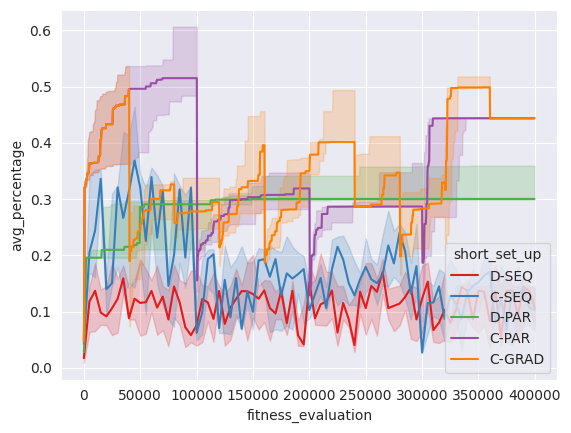

In [11]:
g = sns.lineplot(
    data=progression_df,
    x="fitness_evaluation",
    y="avg_percentage",
    hue="short_set_up",
    estimator="median",
    errorbar=("pi", 50),
    palette="Set1"
)
plt.show()

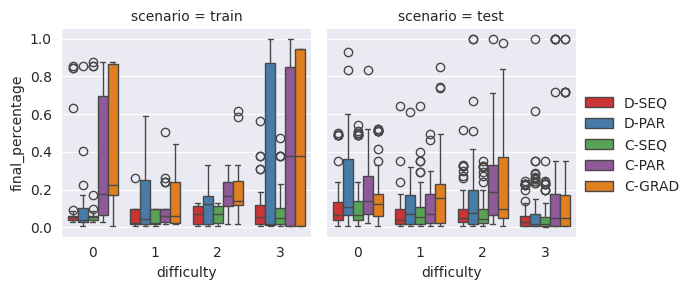

In [12]:
validation_df["difficulty"] = validation_df["prompt"].apply(
    lambda x: 3 if "many" in x else (2 if "some_pipes" in x else (
        1 if "some_enemies" in x else (0 if "no_enemies" in x else int(x.split('_')[1]))))
)
validation_df["scenario"] = validation_df["prompt"].apply(lambda x: x.split("_")[0])
fct = sns.FacetGrid(validation_df[(
        validation_df["difficulty"].isin(range(4)) & ~(validation_df["scenario"] == "original"))],
                    col="scenario")
fct.map_dataframe(sns.boxplot, x="difficulty", y="final_percentage", hue="short_set_up", palette="Set1")
fct.add_legend()
plt.show()

In [13]:
original_validation_df = validation_df[
    (validation_df["scenario"] == "original") & ~(validation_df["short_set_up"].isin(["C1", "D1"]))]
original_median = original_validation_df.groupby(["short_set_up", "difficulty"]).median(
    "final_percentage").reset_index()
original_median["inverted_percentage"] = 1 - original_median["final_percentage"]
rank_dfs = []
for difficulty in original_median["difficulty"].unique():
    curr_df = original_median[original_median["difficulty"] == difficulty]
    curr_df["rank"] = curr_df["inverted_percentage"].rank()
    rank_dfs.append(curr_df)
rank_df = pd.concat(rank_dfs)
rank_df

/tmp/ipykernel_851989/1525666379.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_df["rank"] = curr_df["inverted_percentage"].rank()
/tmp/ipykernel_851989/1525666379.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_df["rank"] = curr_df["inverted_percentage"].rank()
/tmp/ipykernel_851989/1525666379.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

,short_set_up,difficulty,reward,done,dead_time,final_percentage,inverted_percentage,rank
0,C-GRAD,1,-906.649985,50.0,50.0,0.095597,0.904403,4.0
15,C-PAR,1,-902.039155,31.0,31.0,0.099433,0.900567,2.0
30,C-SEQ,1,-901.719693,52.0,52.0,0.099764,0.900236,1.0
45,D-PAR,1,-906.409903,52.0,52.0,0.095865,0.904135,3.0
60,D-SEQ,1,-907.233127,52.0,52.0,0.095029,0.904971,5.0
...,...,...,...,...,...,...,...,...
14,C-GRAD,15,-973.196257,32.0,32.0,0.027238,0.972762,4.0
29,C-PAR,15,-969.423630,21.5,21.5,0.030917,0.969083,1.0
44,C-SEQ,15,-973.196257,32.0,32.0,0.027238,0.972762,4.0
59,D-PAR,15,-973.097885,32.0,32.0,0.027339,0.972661,2.0


## Statistical tests

In [14]:
comparisons = [("C-PAR", "D-PAR"), ("C-SEQ", "D-SEQ"), ("C-PAR", "C-SEQ"), ("D-PAR", "D-SEQ")]

In [15]:
end_of_evo = validation_df[(validation_df["difficulty"] == 3) & (
        validation_df["scenario"] == "train")][["short_set_up", "final_percentage", "seed"]].groupby(
    ["short_set_up", "seed"]).mean("final_percentage").reset_index()
for m1, m2 in comparisons:
    m1_data = end_of_evo[end_of_evo["short_set_up"] == m1]["final_percentage"].to_list()
    m2_data = end_of_evo[end_of_evo["short_set_up"] == m2]["final_percentage"].to_list()
    _, pvalue = ranksums(m1_data, m2_data)
    print(f"{m1} vs {m2}: {pvalue:.3f}")

C-PAR vs D-PAR: 0.066
C-SEQ vs D-SEQ: 0.678
C-PAR vs C-SEQ: 0.000
D-PAR vs D-SEQ: 0.000


In [16]:
test_validation = validation_df[validation_df["scenario"] == "test"]
for difficulty in test_validation["difficulty"].unique():
    print(f"Difficulty {difficulty}")
    for m1, m2 in comparisons:
        m1_data = \
            test_validation[(test_validation["difficulty"] == difficulty) & (test_validation["short_set_up"] == m1)][
                "final_percentage"].to_list()
        m2_data = \
            test_validation[(test_validation["difficulty"] == difficulty) & (test_validation["short_set_up"] == m2)][
                "final_percentage"].to_list()
        _, pvalue = ranksums(m1_data, m2_data)
        print(f"{m1} vs {m2}: {pvalue:.3f}")

Difficulty 0
C-PAR vs D-PAR: 0.351
C-SEQ vs D-SEQ: 0.832
C-PAR vs C-SEQ: 0.000
D-PAR vs D-SEQ: 0.002
Difficulty 1
C-PAR vs D-PAR: 0.402
C-SEQ vs D-SEQ: 0.389
C-PAR vs C-SEQ: 0.155
D-PAR vs D-SEQ: 0.135
Difficulty 2
C-PAR vs D-PAR: 0.000
C-SEQ vs D-SEQ: 0.496
C-PAR vs C-SEQ: 0.000
D-PAR vs D-SEQ: 0.184
Difficulty 3
C-PAR vs D-PAR: 0.145
C-SEQ vs D-SEQ: 0.226
C-PAR vs C-SEQ: 0.020
D-PAR vs D-SEQ: 0.779


In [17]:
full_comparisons = [("C-PAR", "D-PAR"), ("C-SEQ", "D-SEQ"), ("C-PAR", "C-SEQ"), ("D-PAR", "D-SEQ"), ("C-PAR", "D-SEQ"),
                    ("D-PAR", "C-SEQ")]

In [26]:
original_pvalues = []
original_validation = validation_df[validation_df["scenario"] == "original"]
for difficulty in original_validation["difficulty"].unique():
    for m1, m2 in full_comparisons:
        m1_data = original_validation[
            (original_validation["difficulty"] == difficulty) & (original_validation["short_set_up"] == m1)][
            "final_percentage"].to_list()
        m2_data = original_validation[
            (original_validation["difficulty"] == difficulty) & (original_validation["short_set_up"] == m2)][
            "final_percentage"].to_list()
        _, pvalue = ranksums(m1_data, m2_data)
        original_pvalues.append({
            "m1": m1,
            "m2": m2,
            "pvalue": pvalue
        })
original_pvalues_df = pd.DataFrame(original_pvalues)
original_pvalues_df.head()

,m1,m2,pvalue
0,C-PAR,D-PAR,0.870283
1,C-SEQ,D-SEQ,0.241322
2,C-PAR,C-SEQ,0.762369
3,D-PAR,D-SEQ,0.120819
4,C-PAR,D-SEQ,0.058782


In [37]:
# tables
difficulty = 3
vals = ["C-PAR", "C-SEQ", "C-GRAD", "D-PAR", "D-SEQ"]
print("\\begin{tabular}{lccccc}")
print("\\toprule")
print(f"& {' & '.join(vals)} \\\\")
print("\\midrule")
for y_idx, y_val in enumerate(vals):
    row = f"{y_val}"
    for x_idx, x_val in enumerate(vals):
        if x_val == y_val:
            row += f" & \\color{{gray!30}}---"
        else:
            m1_data = test_validation[
                (test_validation["difficulty"] == difficulty) & (test_validation["short_set_up"] == x_val)][
                "final_percentage"].to_list()
            m2_data = test_validation[
                (test_validation["difficulty"] == difficulty) & (test_validation["short_set_up"] == y_val)][
                "final_percentage"].to_list()
            _, pvalue = ranksums(m1_data, m2_data)
            if x_idx > y_idx:
                row += f" & {pvalue:.3f}"
            else:
                row += f" & \\color{{gray!30}}{pvalue:.3f}"
    print(f"{row} \\\\")
print("\\bottomrule")
print("\\end{tabular}")

\begin{tabular}{lccccc}
\toprule
& C-PAR & C-SEQ & C-GRAD & D-PAR & D-SEQ \\
\midrule
C-PAR & \color{gray!30}--- & 0.020 & 0.928 & 0.145 & 0.160 \\
C-SEQ & \color{gray!30}0.020 & \color{gray!30}--- & 0.015 & 0.444 & 0.226 \\
C-GRAD & \color{gray!30}0.928 & \color{gray!30}0.015 & \color{gray!30}--- & 0.100 & 0.156 \\
D-PAR & \color{gray!30}0.145 & \color{gray!30}0.444 & \color{gray!30}0.100 & \color{gray!30}--- & 0.779 \\
D-SEQ & \color{gray!30}0.160 & \color{gray!30}0.226 & \color{gray!30}0.156 & \color{gray!30}0.779 & \color{gray!30}--- \\
\bottomrule
\end{tabular}


## Export data

In [13]:
data_export = False

from statistics import median
from typing import List, Union

from pandas import DataFrame


def line_plot(df: DataFrame, x: str, y: Union[List[str], str], groups: Union[List[str], str] = None,
              file_prefix: str = "", cols_joiner: str = "_", filename_joiner: str = "_"):
    """ Exports data to individual files for line plots with median as main line and shaded area between quartiles.

        Parameters:
        df : dataframe
        x : x-axis column
        y : y-axis column(s)
        groups : grouping variable column(s)
        file_prefix : prefix to prepend to every file generated
        cols_joiner : joiner for columns
        filename_joiner : joiner for file name

       """

    if type(y) == str:
        y = [y]
    if type(groups) == str:
        groups = [groups]

    def q1(a):
        return a.quantile(0.25)

    def q3(b):
        return b.quantile(0.75)

    vals = dict([(key, [q1, q3, median]) for key in y])

    summary = df.groupby(groups + [x]).agg(vals)
    summary.columns = [cols_joiner.join(col) for col in summary.columns.to_flat_index()]
    summary.reset_index(inplace=True)

    key_df = df.drop_duplicates(subset=groups)

    for i in range(len(key_df)):
        tmp = summary
        current_filename = file_prefix
        for key in groups:
            tmp = tmp[tmp[key] == key_df[key].iloc[i]]
            current_filename += f"{filename_joiner if len(current_filename) > 0 and not current_filename.endswith('/') else ''}{key_df[key].iloc[i]}"
        tmp.to_csv(f"{current_filename}.txt", sep="\t", index=False)


def box_plot(df: DataFrame, x: str, y: str, groups: Union[List[str], str] = None, file_prefix: str = "",
             filename_joiner: str = "_"):
    """ Exports data to individual files for box plots.

        Parameters:
        df : dataframe
        x : x-axis column
        y : y-axis column(s)
        groups : grouping variable column(s)
        file_prefix : prefix to prepend to every file generated
        cols_joiner : joiner for columns
        filename_joiner : joiner for file name

       """

    if type(groups) == str:
        groups = [groups]
    if groups is None or len(groups) == 0:
        _box_plot(df, x, y, file_prefix)

    else:
        key_df = df.drop_duplicates(subset=groups)

        for i in range(len(key_df)):
            tmp = df
            current_filename = file_prefix
            for key in groups:
                tmp = tmp[tmp[key] == key_df[key].iloc[i]]
                current_filename += f"{filename_joiner if len(current_filename) > 0 else ''}{key_df[key].iloc[i]}"
            _box_plot(tmp, x, y, current_filename)


def _box_plot(df: DataFrame, x: str, y: str, file_name: str):
    plt.figure(visible=False)
    data = []
    for xi in df[x].unique():
        data.append([k for k in df[df[x] == xi][y] if str(k) != "nan"])

    bp = plt.boxplot(data, showmeans=False)

    minimums = [round(item.get_ydata()[0], 1) for item in bp['caps']][::2]
    q1 = [round(min(item.get_ydata()), 1) for item in bp['boxes']]
    medians = [item.get_ydata()[0] for item in bp['medians']]
    q3 = [round(max(item.get_ydata()), 1) for item in bp['boxes']]
    maximums = [round(item.get_ydata()[0], 1) for item in bp['caps']][1::2]

    rows = [df[x].unique().tolist(), minimums, q1, medians, q3, maximums]

    with open(f"{file_name}.txt", "w") as bp_file:
        for row in rows:
            bp_file.write("\t".join(map(str, row)) + "\n")

In [14]:
line_plot(progression_df, x="fitness_evaluation", y="avg_percentage", groups="short_set_up",
          file_prefix="../pgfplots/mario_evo")

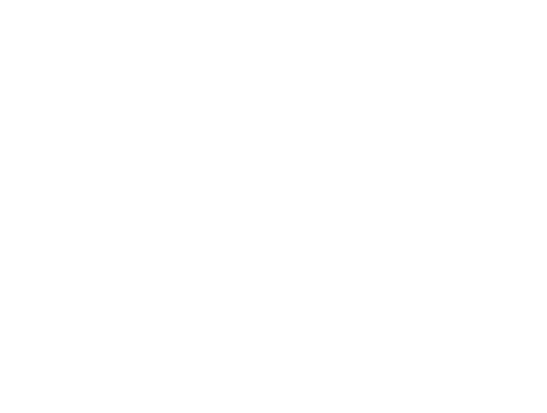

In [15]:
end_of_evo = validation_df[(validation_df["difficulty"] == 3) & (
        validation_df["scenario"] == "train")][["short_set_up", "final_percentage", "seed"]].groupby(
    ["short_set_up", "seed"]).mean("final_percentage").reset_index()
box_plot(end_of_evo, file_prefix="../pgfplots/mario_end_of_evo", y="final_percentage", x="short_set_up")

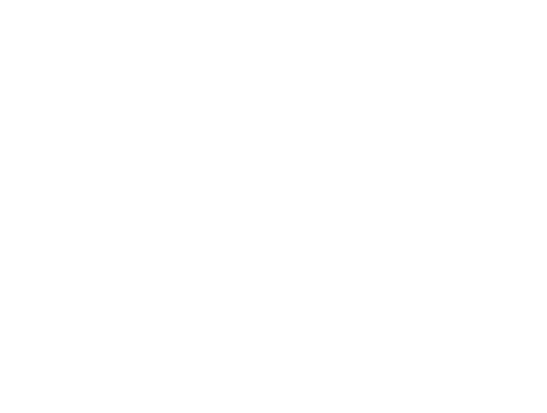

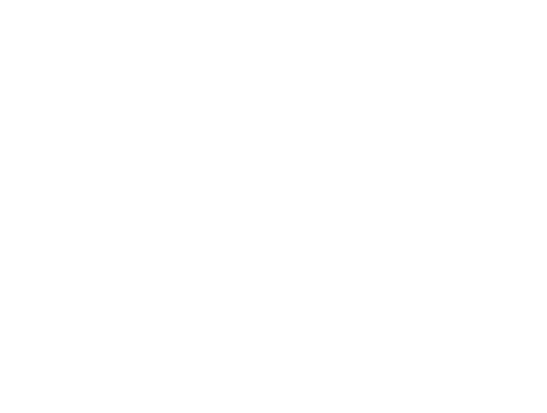

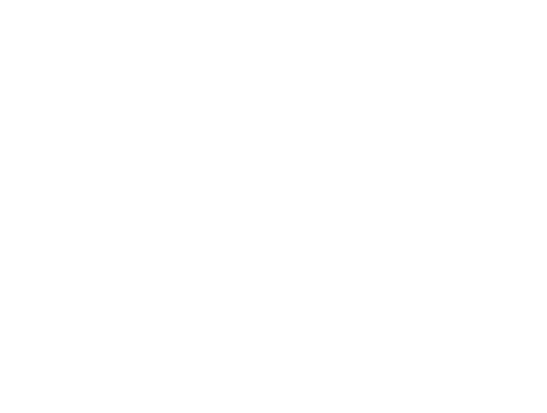

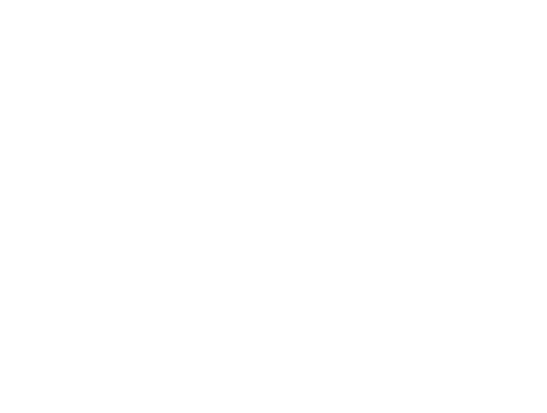

In [16]:
test_validation = validation_df[validation_df["scenario"] == "test"]
box_plot(test_validation, file_prefix="../pgfplots/mario_validation", y="final_percentage", x="short_set_up",
         groups="difficulty")

In [48]:
import math

string_values = ""

for method in ["C-PAR", "C-SEQ", "C-GRAD", "D-PAR", "D-SEQ"]:
    ddf = rank_df[rank_df["short_set_up"] == method].sort_values(by=["difficulty"], ascending=True)
    string_values += (method + " & " + " & ".join([str(math.floor(x)) for x in ddf["rank"].tolist()]) + "\n")
    string_values += f"& {math.floor(sum(ddf['rank'].tolist()))} \\\\ \n"

print(string_values.replace(" 1", " \\textbf{1}"))

C-PAR & 2 & \textbf{1} & 2 & \textbf{1} & \textbf{1} & 3 & \textbf{1} & \textbf{1} & \textbf{1} & 3 & 3 & \textbf{1} & 3 & \textbf{1} & \textbf{1}
& 27 \\ 
C-SEQ & \textbf{1} & 5 & 4 & 5 & 3 & 4 & 4 & 5 & \textbf{1} & 4 & 4 & 4 & 5 & 5 & 4
& 59 \\ 
C-GRAD & 4 & 3 & \textbf{1} & \textbf{1} & 5 & \textbf{1} & \textbf{1} & 3 & 4 & \textbf{1} & 2 & \textbf{1} & 2 & 2 & 4
& 37 \\ 
D-PAR & 3 & 2 & 3 & 3 & 3 & 2 & 4 & 2 & 3 & 2 & \textbf{1} & 4 & \textbf{1} & 3 & 2
& 39 \\ 
D-SEQ & 5 & 4 & 5 & 3 & 2 & 5 & 4 & 4 & 4 & 5 & 5 & 4 & 4 & 3 & 4
& 62 \\ 



In [41]:
for difficulty in rank_df["difficulty"].unique():
    first_method_list = rank_df[(rank_df["difficulty"] == difficulty) & (rank_df["rank"] == 1)]["short_set_up"].tolist()
    if len(first_method_list) == 0:
        continue
    first_method = first_method_list[0]
    print(f"{difficulty} --> {first_method}")
    other_methods = rank_df[(rank_df["difficulty"] == difficulty) & (rank_df["rank"] > 1)]["short_set_up"].tolist()
    for other_method in other_methods:
        pvalue = original_pvalues_df[
            ((original_pvalues_df["m1"] == first_method) & (original_pvalues_df["m2"] == other_method)) | (
                    original_pvalues_df["m2"] == first_method) & (original_pvalues_df["m1"] == other_method)][
            "pvalue"].tolist()[0]
        print(f"{other_method} - {pvalue}")

1 --> C-SEQ


IndexError: list index out of range